### RLab06 - Martina Cacciola (2097476)

In [1]:
library(tidyverse)
library(ggplot2)
library(lubridate)
library(dplyr)
library(tidyr)
library(gridExtra)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: 'gridExtra'


Il seguente oggetto è mascherato da 'package:dplyr':

    combine




# Exercise  1

In [2]:
Sys.setenv(PATH = "C:\\Program Files\\JAGS\\JAGS-4.1.0\\x64\\bin")

In [3]:
Sys.setenv(JAGS_HOME="C:\\Program Files\\JAGS\\JAGS-4.1.0")

In [6]:
install.packages("rjags", type = "binary")
install.packages("runjags", type = "binary")


  C'è una versione binaria disponibile (e sarà installata) ma la
  versione dei sorgenti è successiva:
      binary source
rjags   4-13   4-14

package 'rjags' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rjags'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema durante la copia di D:\anaconda\envs\r-env\Lib\R\library\00LOCK\rjags\libs\x64\rjags.dll in D:\anaconda\envs\r-env\Lib\R\library\rjags\libs\x64\rjags.dll: Permission denied"
Warning message:
"restored 'rjags'"



The downloaded binary packages are in
	C:\Users\scumb\AppData\Local\Temp\RtmpI9VYdn\downloaded_packages
package 'runjags' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\scumb\AppData\Local\Temp\RtmpI9VYdn\downloaded_packages


In [4]:
library(rjags)
library(runjags)

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.1.0

Loaded modules: basemod,bugs


Caricamento pacchetto: 'runjags'


Il seguente oggetto è mascherato da 'package:tidyr':

    extract




Acceptance Rate: 0.71168

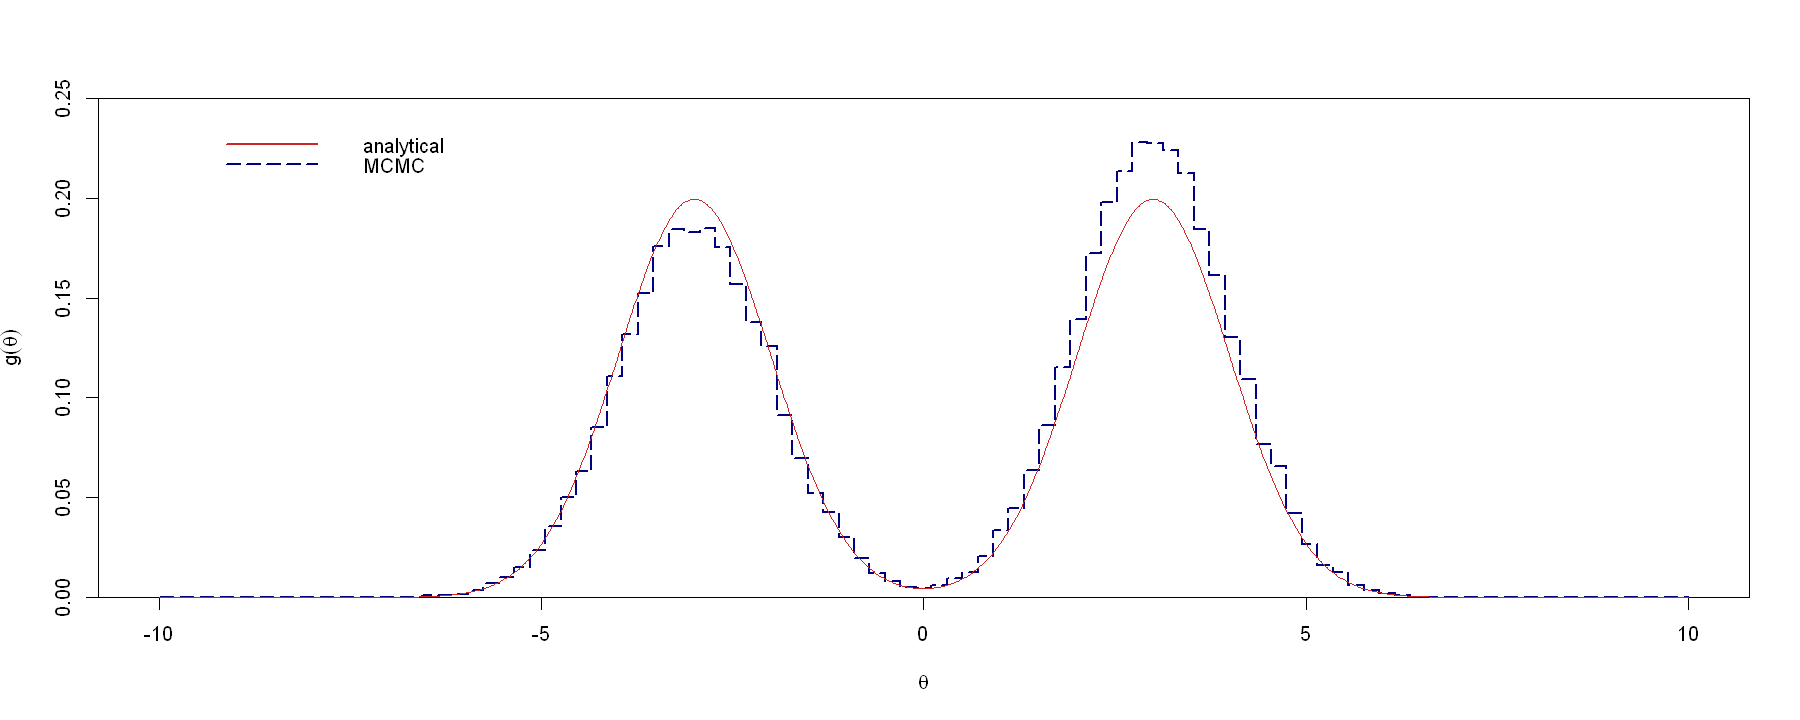

In [45]:
# Define the un-normalized posterior distribution
g <- function(theta) {
  return (0.5 * exp(-(theta + 3)^2 / 2) + 0.5 * exp(-(theta - 3)^2 / 2))
}

# Normalize the posterior distribution
normalize <- function(func, lower, upper, n = 1000) {
  integral <- integrate(func, lower, upper)$value
  x <- seq(lower, upper, length.out = n)
  y <- func(x) / integral
  return(list(x = x, y = y))
}
normalized_func <- normalize(g, -10, 10)

# Metropolis-Hastings algorithm
g.metropolis <- function(theta) {
  return(log(g(theta)))
}

metropolis_1dim <- function(func, theta.init, n.sample, sigma) {
  theta.cur <- theta.init
  func.Cur <- func(theta.cur)
  func.Samp <- matrix(data = NA, nrow = n.sample, ncol = 2 + 1)
  n.accept <- 0
  rate.accept <- 0.0
  
  for (n in 1:n.sample) {
    theta.prop <- rnorm(n = 1, mean = theta.cur, sd = sigma)
    func.Prop <- func(theta.prop)
    logMR <- func.Prop - func.Cur
    
    if (logMR >= 0 || logMR > log(runif(1))) {
      theta.cur <- theta.prop
      func.Cur <- func.Prop
      n.accept <- n.accept + 1
    }
    
    func.Samp[n, 1] <- func.Cur
    func.Samp[n, 2] <- theta.cur
  }
  
  
  # Calculate acceptance rate
  acceptance_rate <- n.accept / n.sample
  # Print acceptance rate
  cat("Acceptance Rate:", acceptance_rate)
  # Return the sample matrix 
  return(func.Samp)
}

# Set the number of iterations and initial value
theta.init <- 0
sample.sig <- 1
n.sample <- 10^5
set.seed(20190513)

# Generate Markov Chain
chain <- metropolis_1dim(func = g.metropolis,
                         theta.init = theta.init,
                         n.sample = n.sample,
                         sigma = sample.sig)


# Plot the sampled distribution
x <- seq(-10, 10, length.out = 10^4)
y <- g(x)
ymax <- 1.05 * max(y)

plot(x, y, type = "n", yaxs = "i", ylim = c(0, 0.25),
     xlab = expression(theta), ylab = expression(g(theta)))

sa <- which(chain[, 2] >= min(x) & chain[, 2] <= max(x))
hist <- hist(chain[sa, 2], breaks = seq(from = min(x), to = max(x), length.out = 100), plot = FALSE)
Zhist <- sum(hist$counts) * diff(range(hist$breaks)) / length(hist$counts)* max(y)
lines(hist$breaks, c(hist$counts * ymax / Zhist, 0),
      col = 'navy', type = "s", lwd = 2, lty = 5)

lines(normalized_func$x, normalized_func$y, col = 'firebrick3', lwd = 1, lty = 1)

leg.labels <- c('analytical', 'MCMC')
leg.colors <- c('firebrick3', 'navy')

legend("topleft", inset = 0.05, bty = 'n',
       legend = leg.labels, col = leg.colors,
       lwd = 2, lty = c(1, 5))

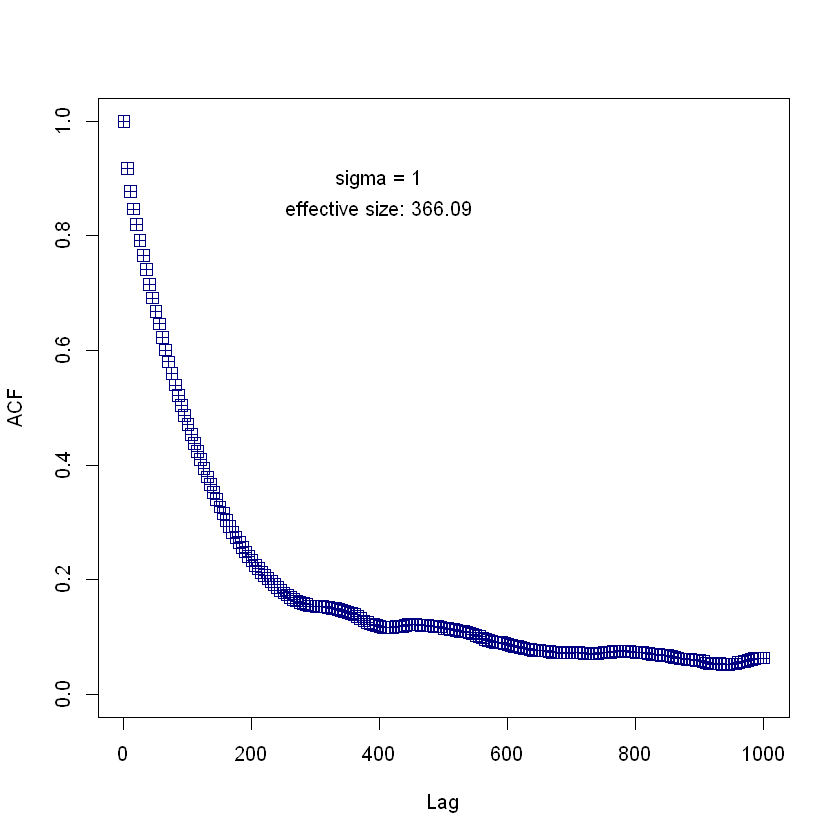

In [22]:
# Calculate autocorrelation of the chain
chain_mcmc <- as.mcmc(chain[,2])
my_lags <- seq(0, 1000, 5)
chain_acf <- autocorr(chain_mcmc, lags = my_lags)

# Plot the autocorrelation
plot(my_lags, chain_acf, ylim = c(0, 1),
     pch = 12, col = 'navy',
     xlab = 'Lag', ylab = 'ACF', cex = 1.3)
text(400, 0.9, paste('sigma = 1'))
text(400, 0.85, sprintf("effective size: %.2f", effectiveSize(chain_mcmc)))

In [46]:
# Set the number of iterations and initial value
theta.init <- 0
sample.sig <- 1
n.sample <- 10^5
n.accept <- 0
set.seed(20190513)

# Define the Metropolis-Hastings algorithm with burn-in and thinning
metropolis_new <- function(func, theta.init, n.sample, n.accept, sigma, burn_in, thinning) {
    f <- metropolis_1dim(func, theta.init, n.sample, sigma)
    # Remove the burn-in period from the chain (discard initial values)
    f_red <- tail(f[, 2], n = (length(f[, 2]) - burn_in))
    # Number of iterations in the thinned chain
    int <- as.integer((n.sample - burn_in) / thinning) 
    f_new <- matrix(data = NA, nrow = seq(1:int), ncol = 1)

    for (i in 1:int) {
        f_new[i] <- f_red[i * thinning]
    }
    return(f_new)
}

Acceptance Rate: 0.71265Acceptance Rate: 0.71108

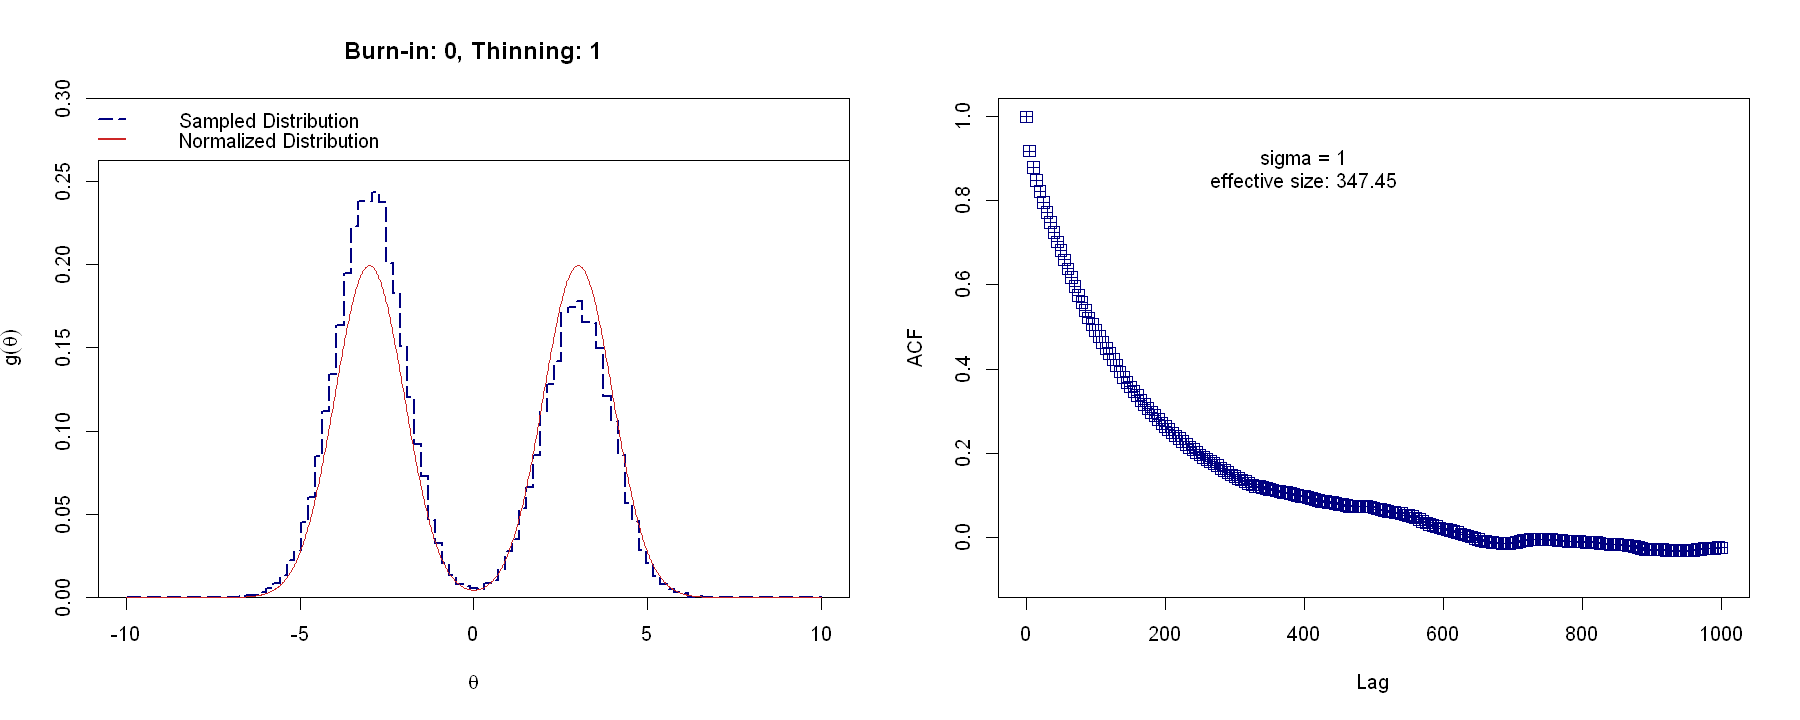

Acceptance Rate: 0.71167

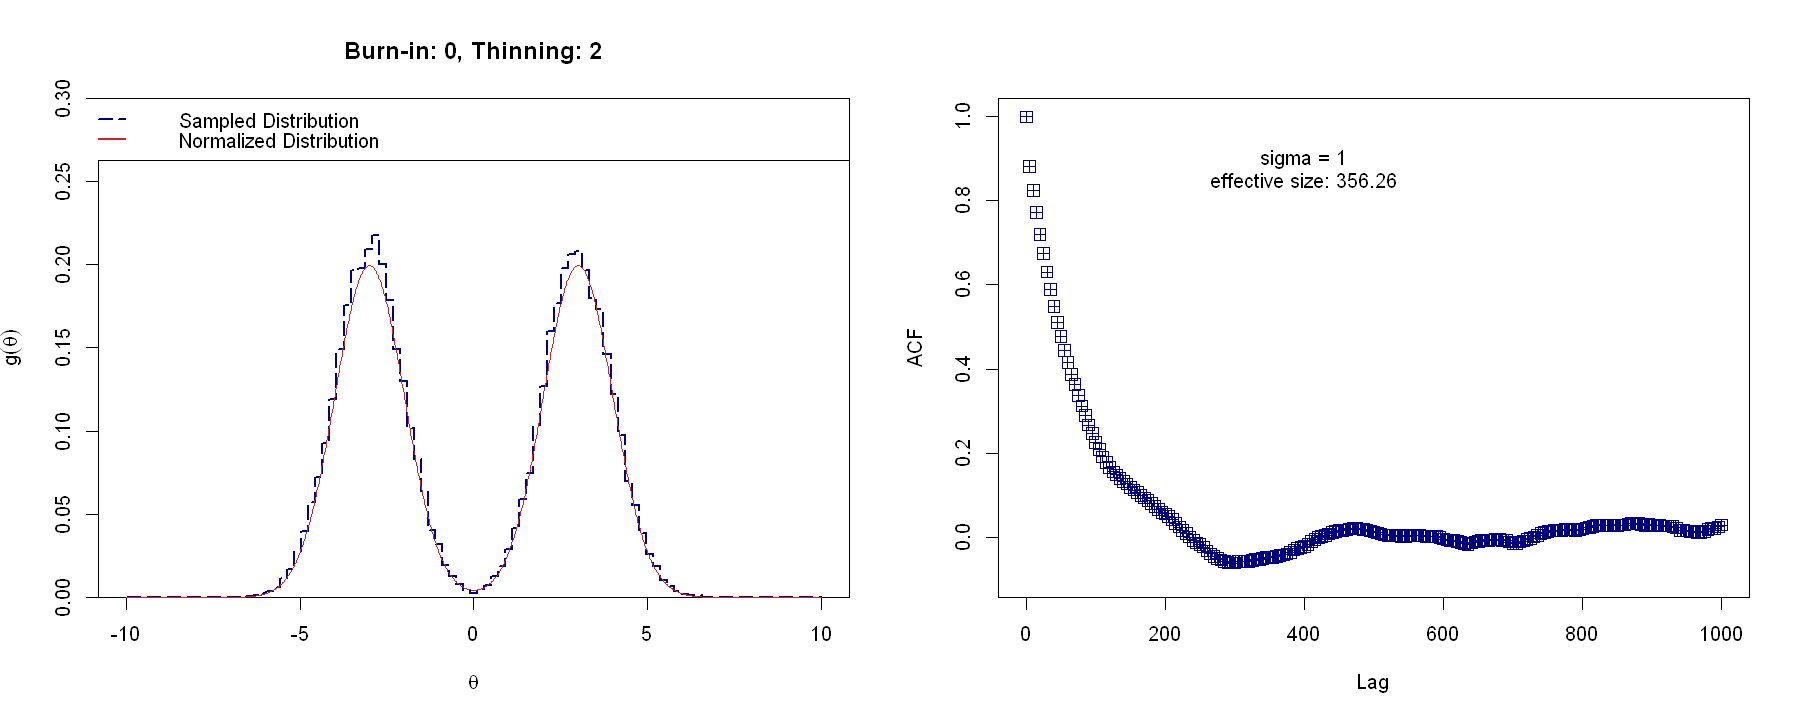

Acceptance Rate: 0.71314

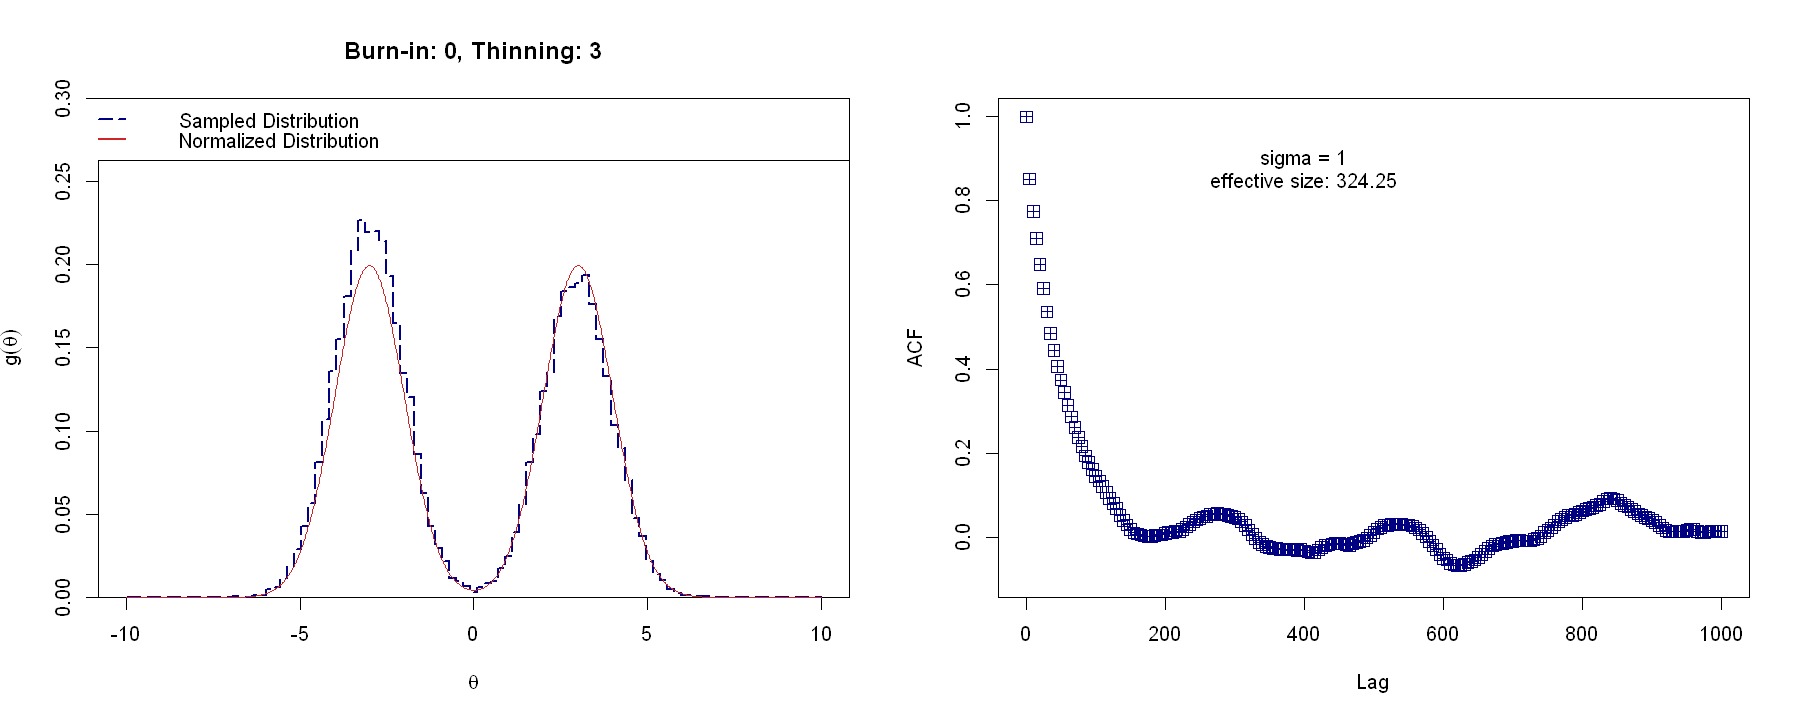

Acceptance Rate: 0.71034

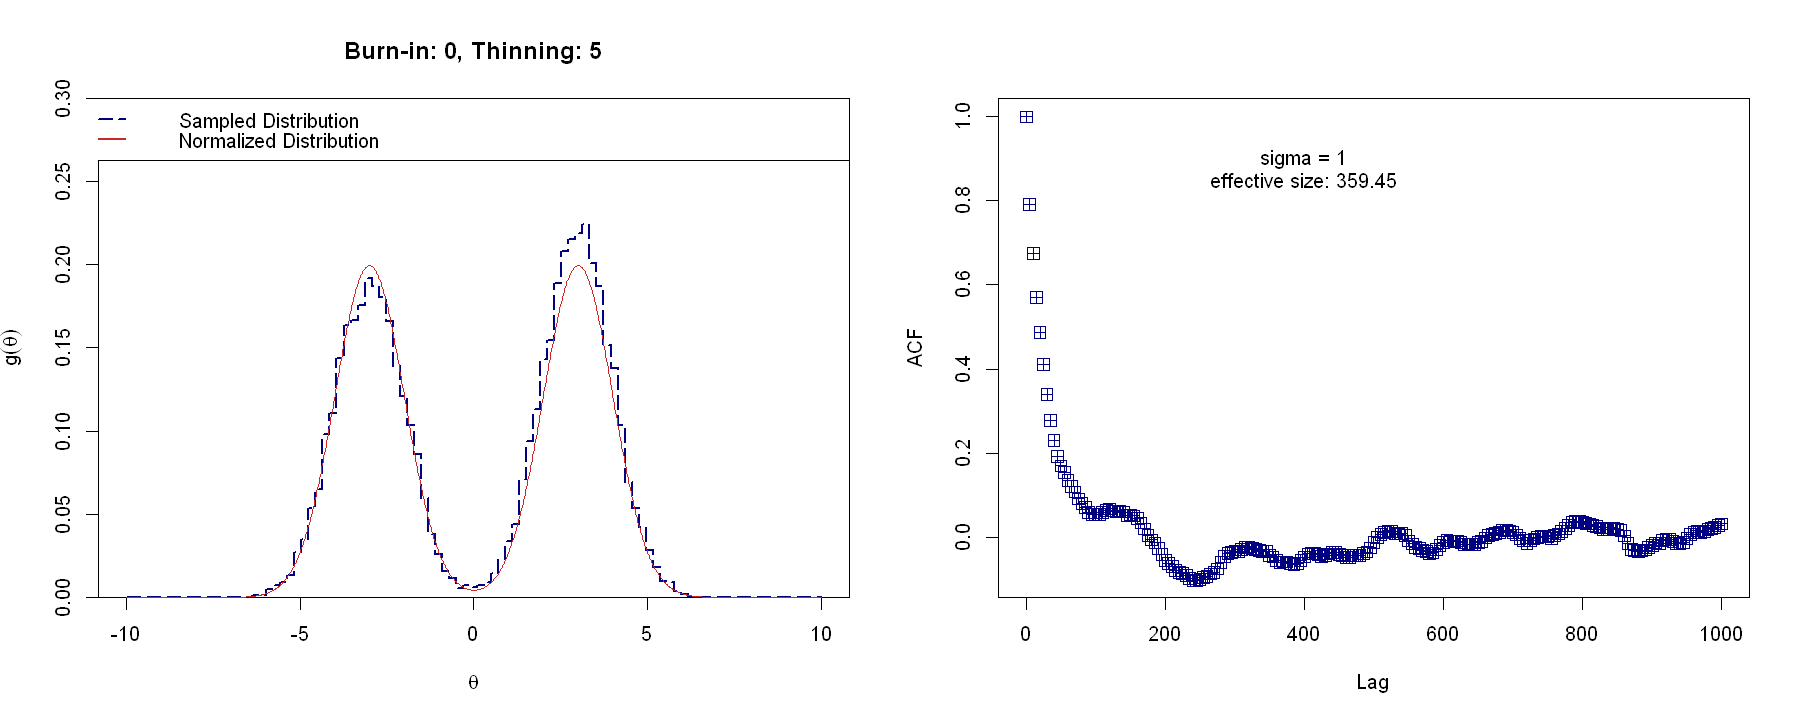

Acceptance Rate: 0.70889

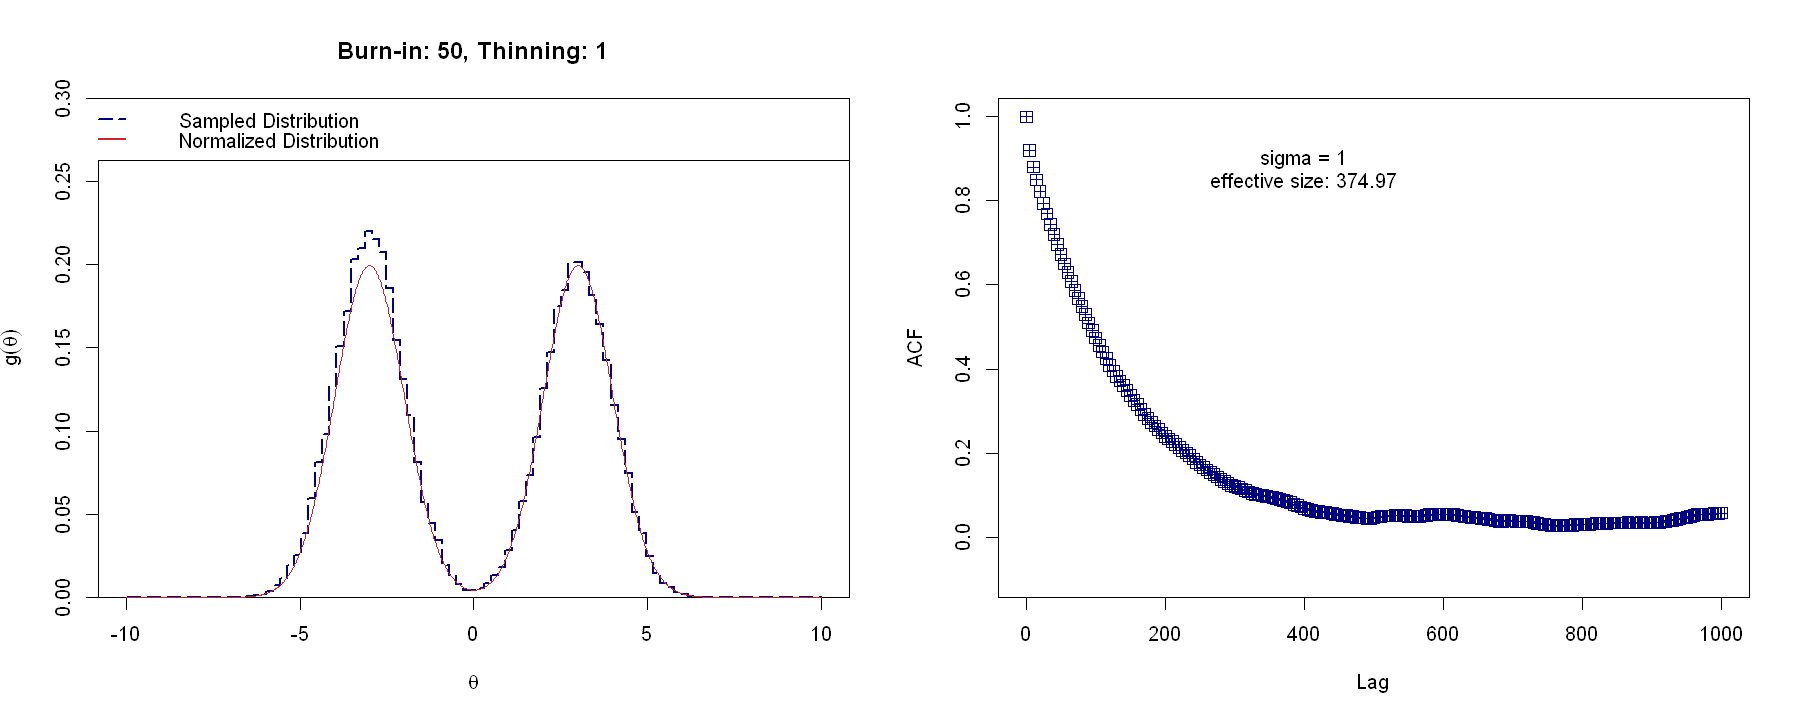

Acceptance Rate: 0.70904

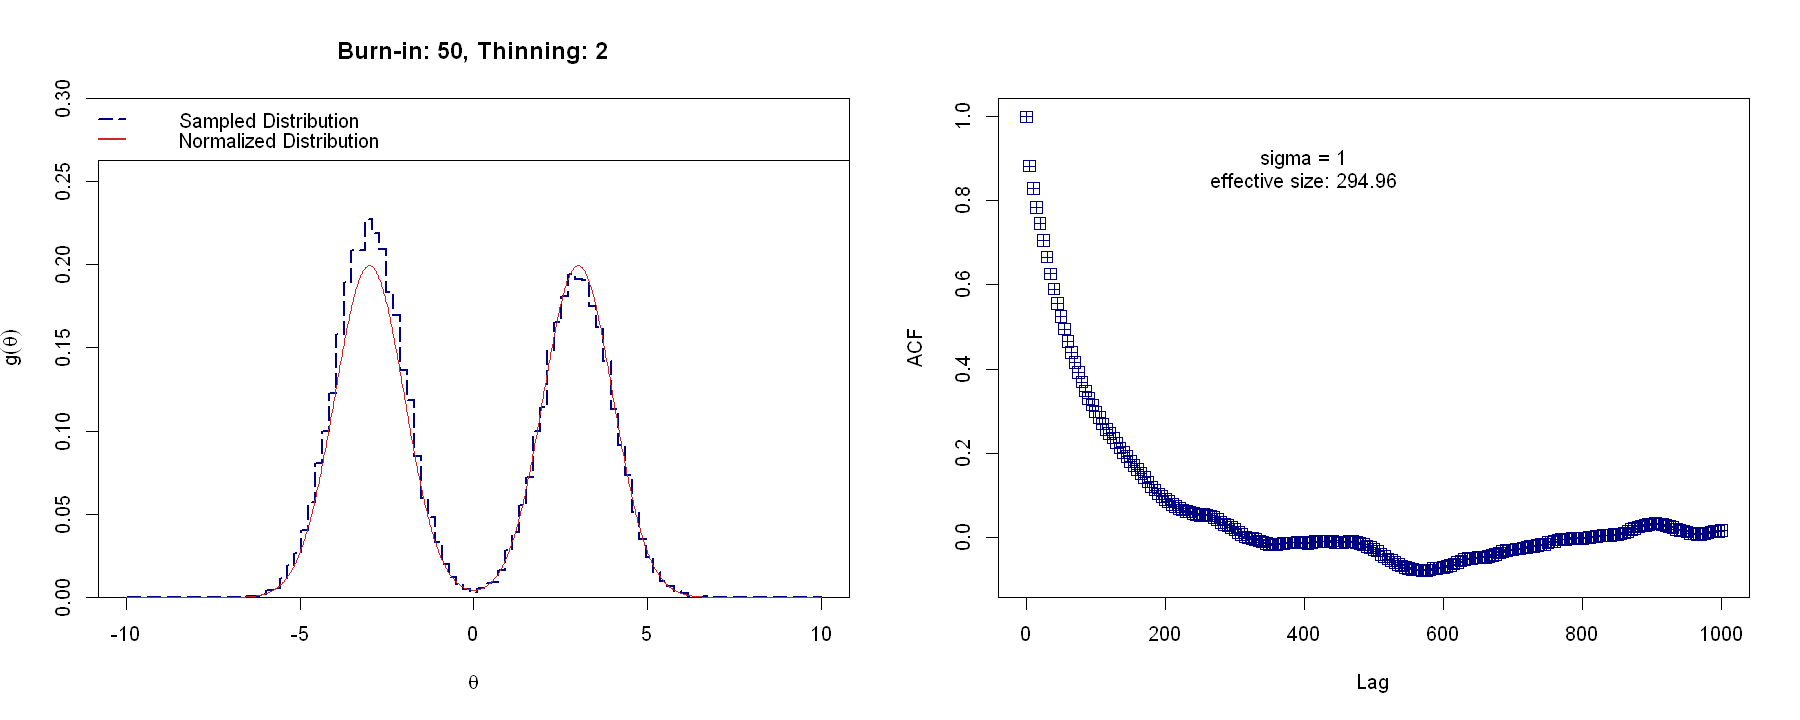

Acceptance Rate: 0.70963

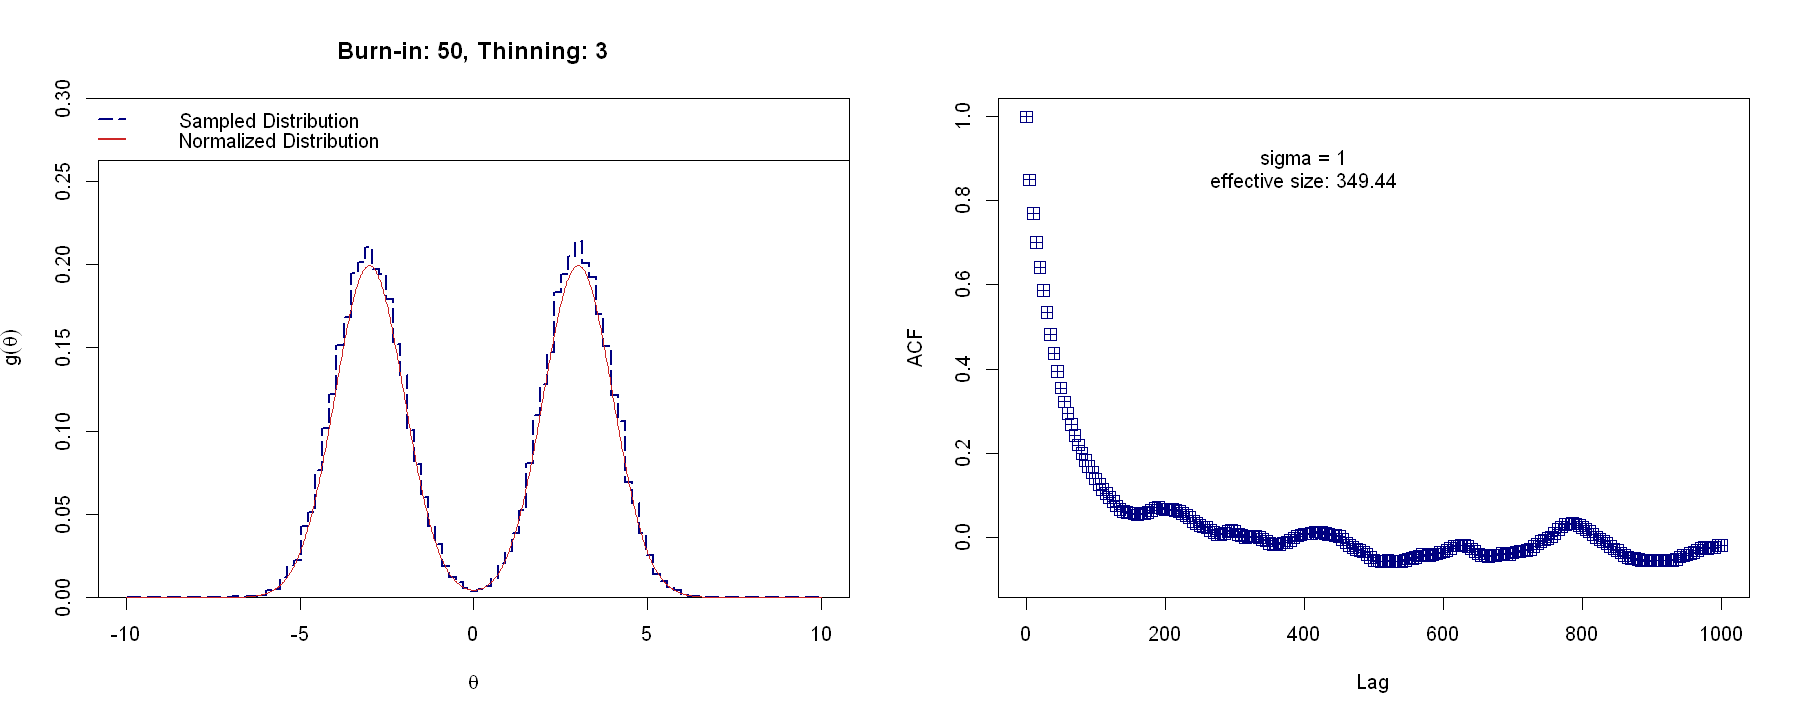

Acceptance Rate: 0.7097

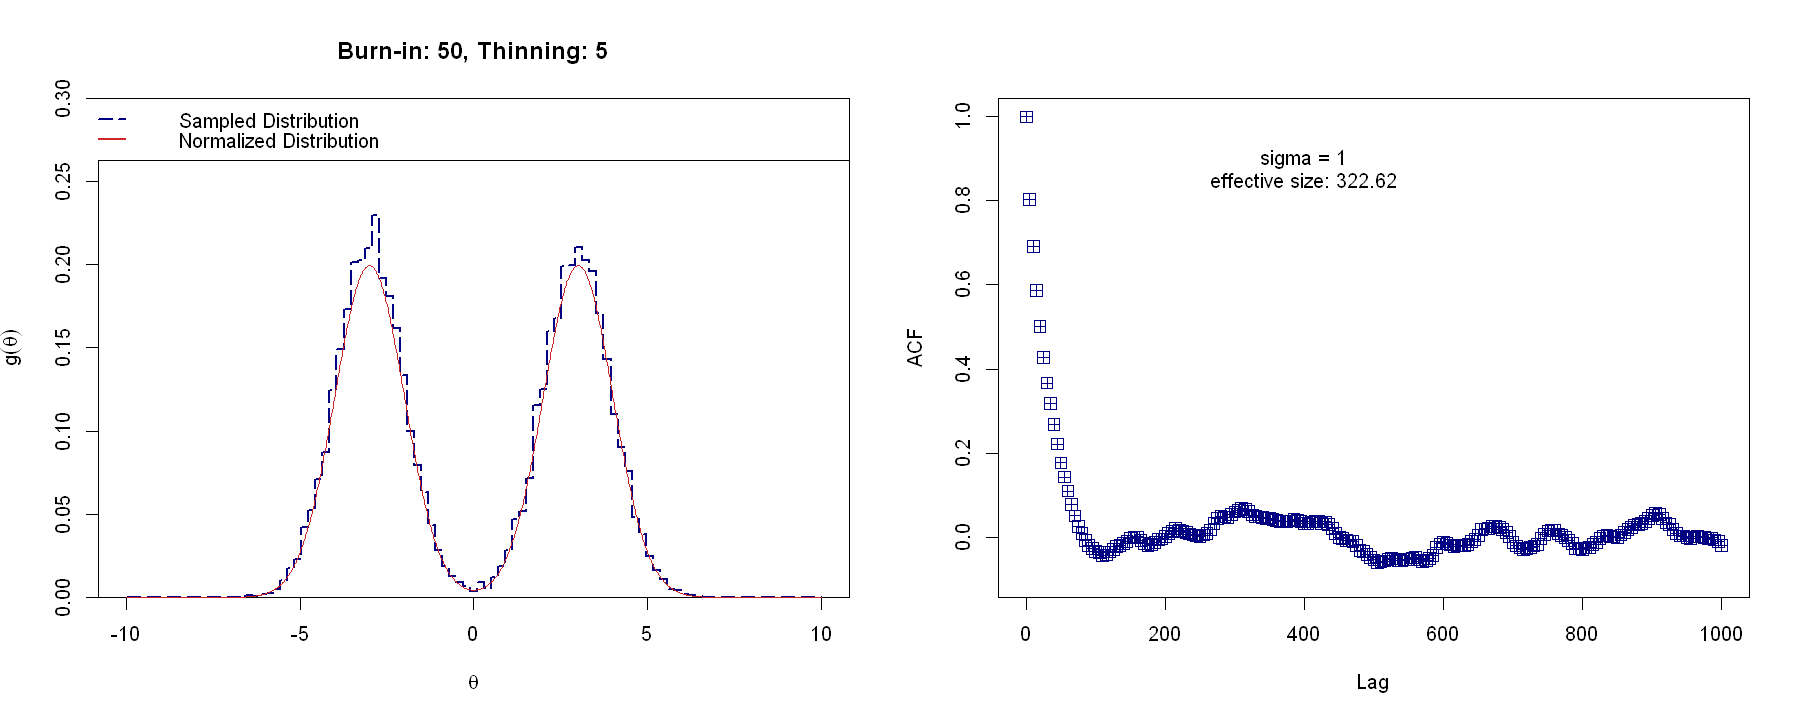

Acceptance Rate: 0.71127

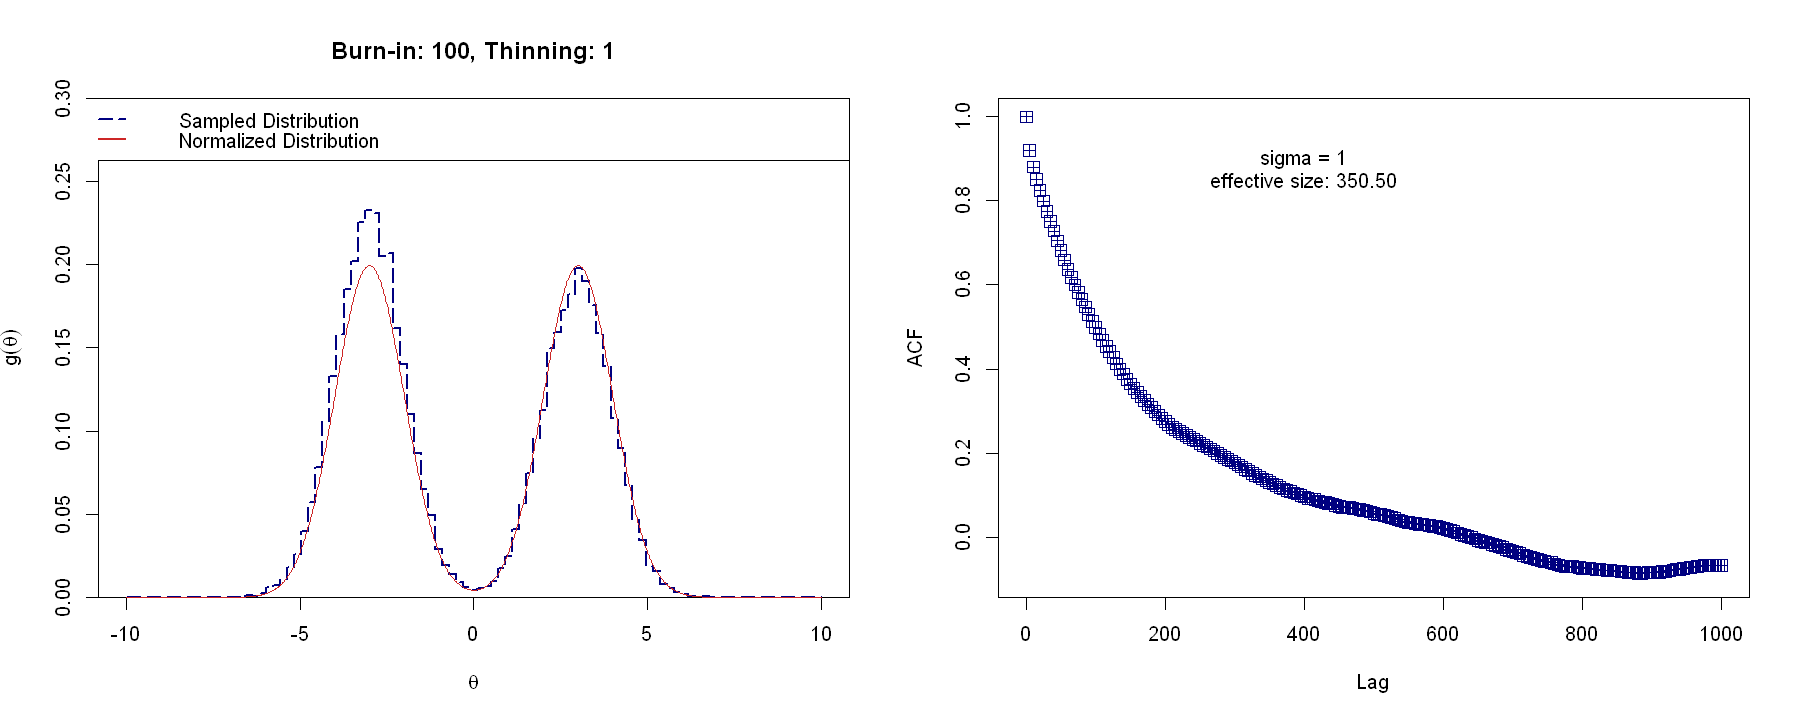

Acceptance Rate: 0.71204

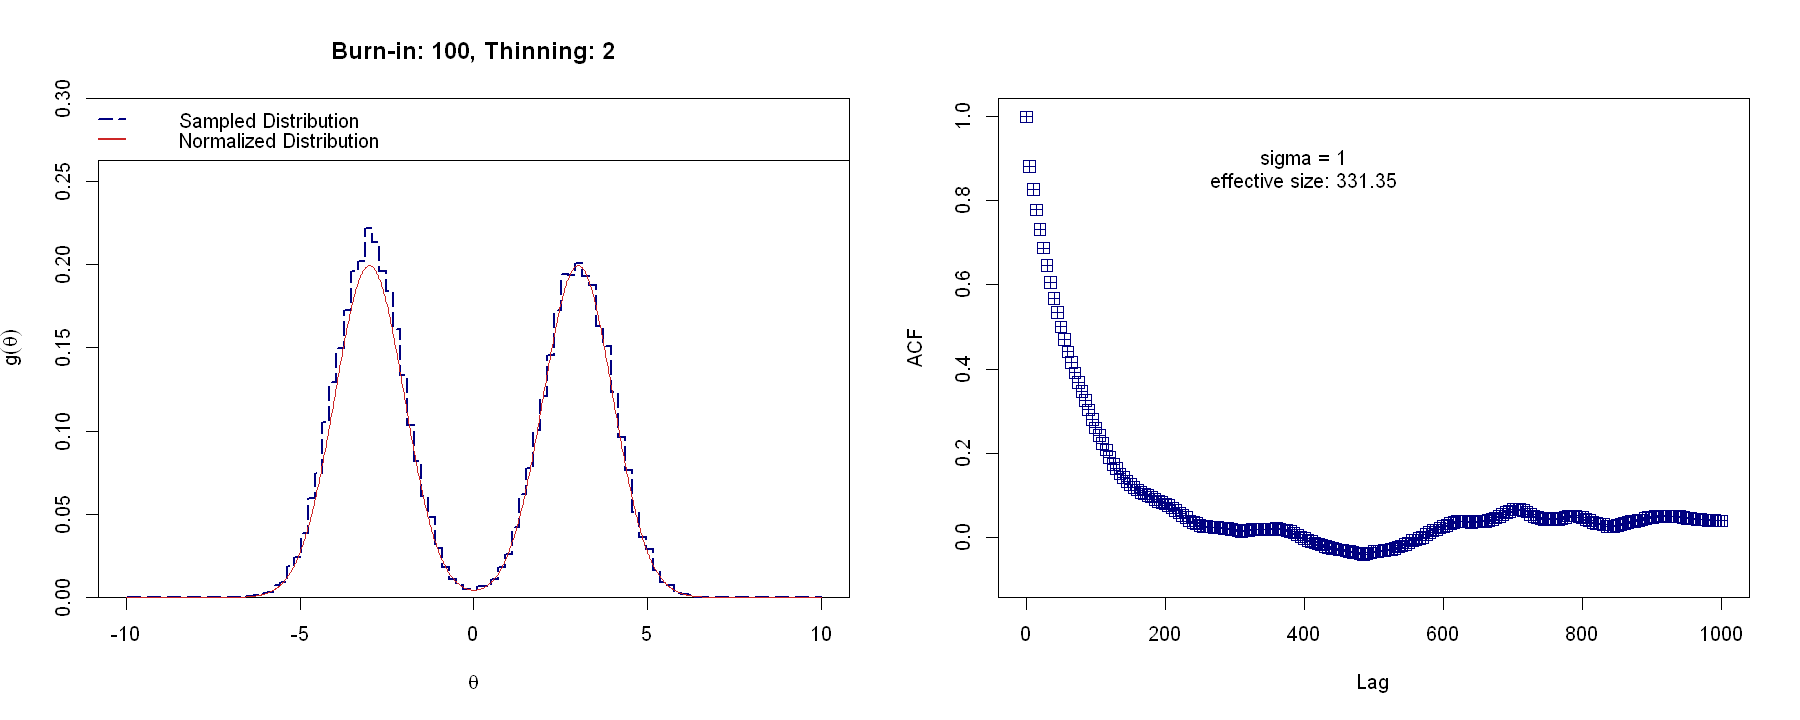

Acceptance Rate: 0.71302

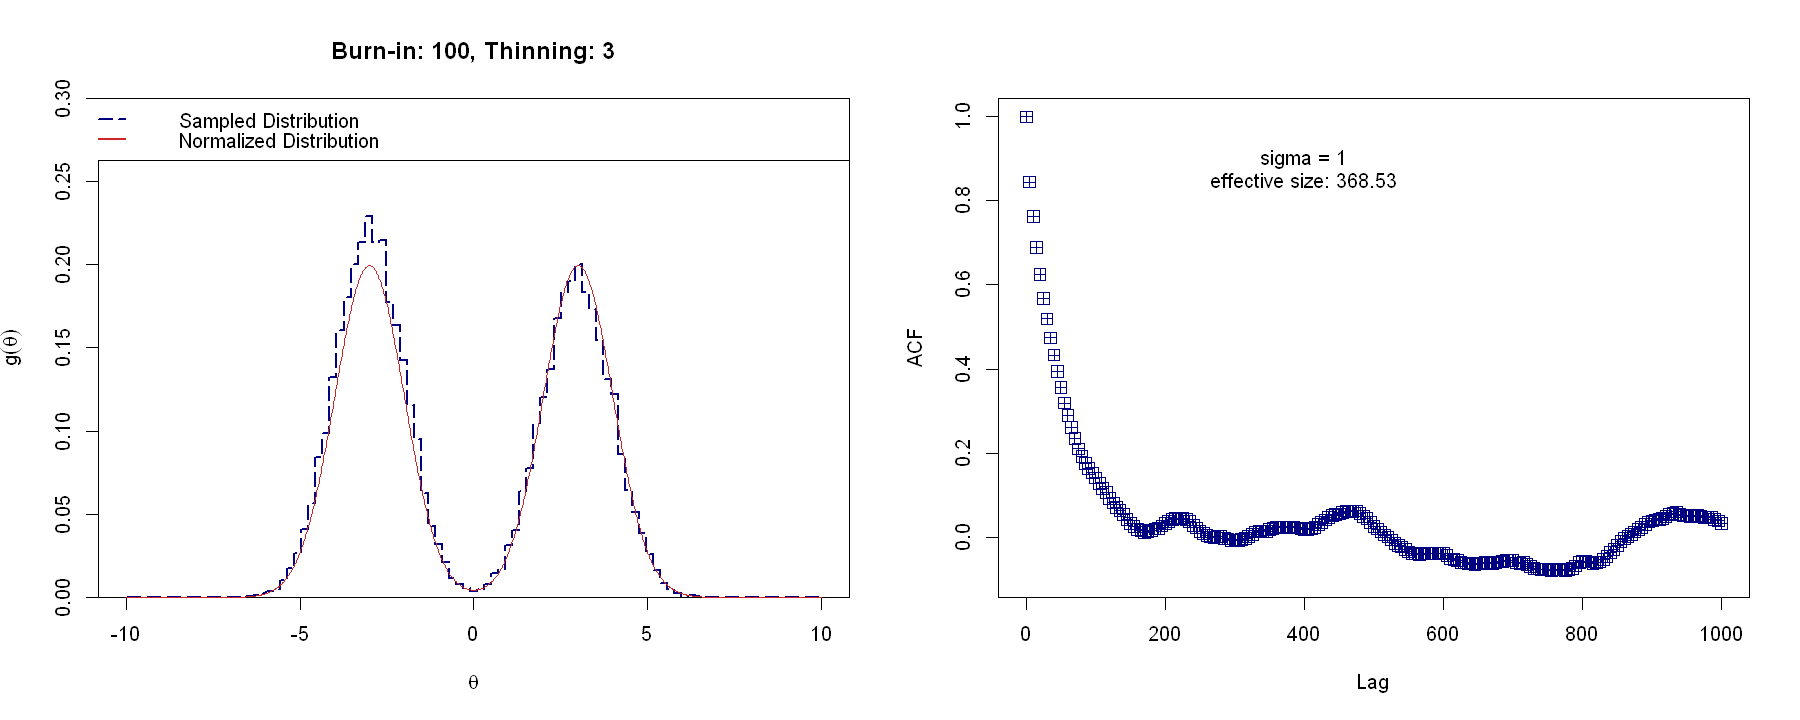

Acceptance Rate: 0.70998

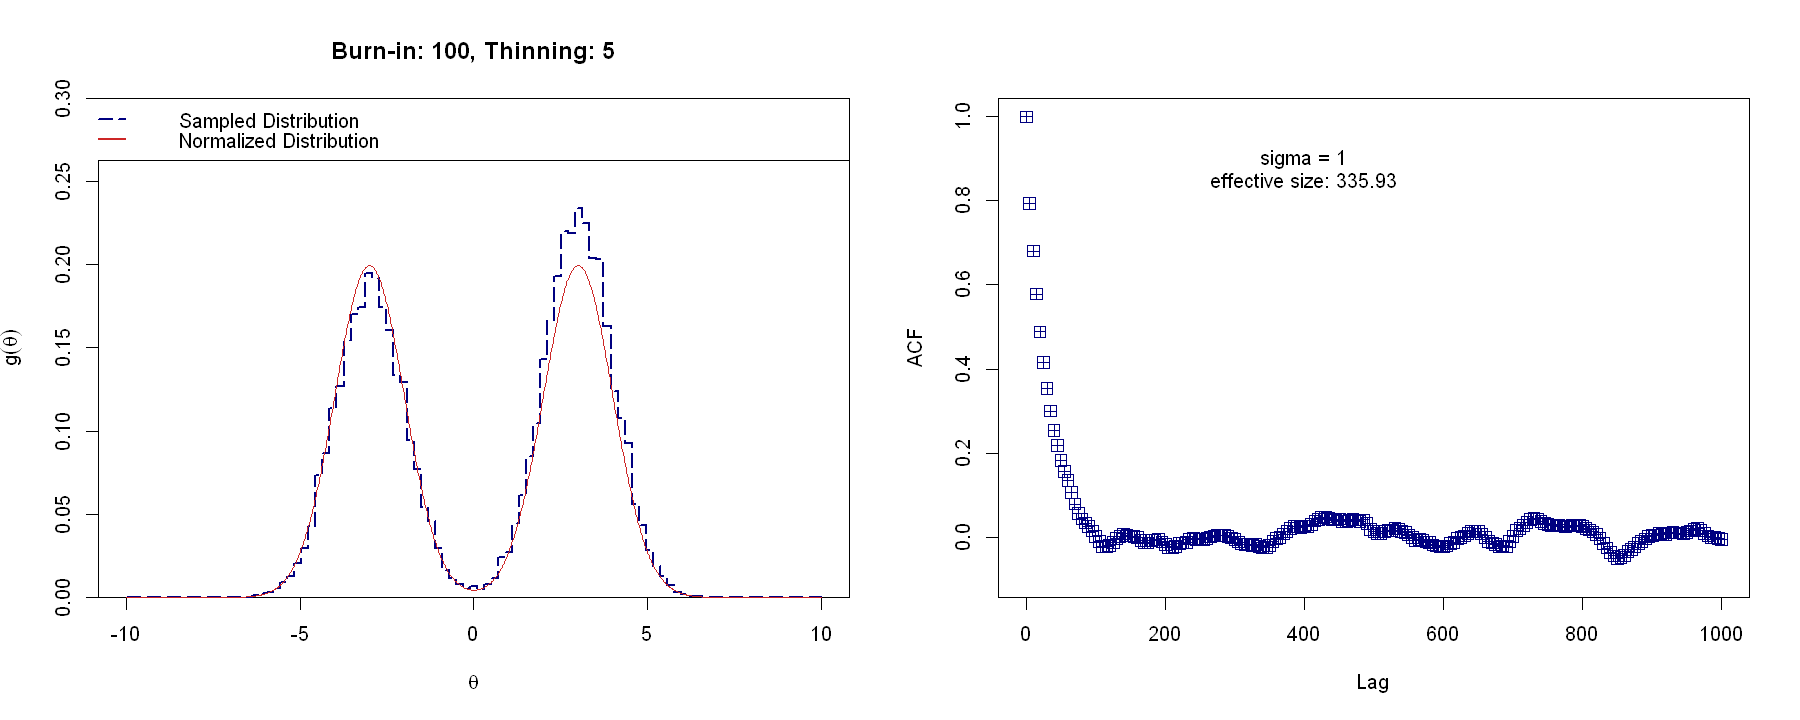

Acceptance Rate: 0.71075

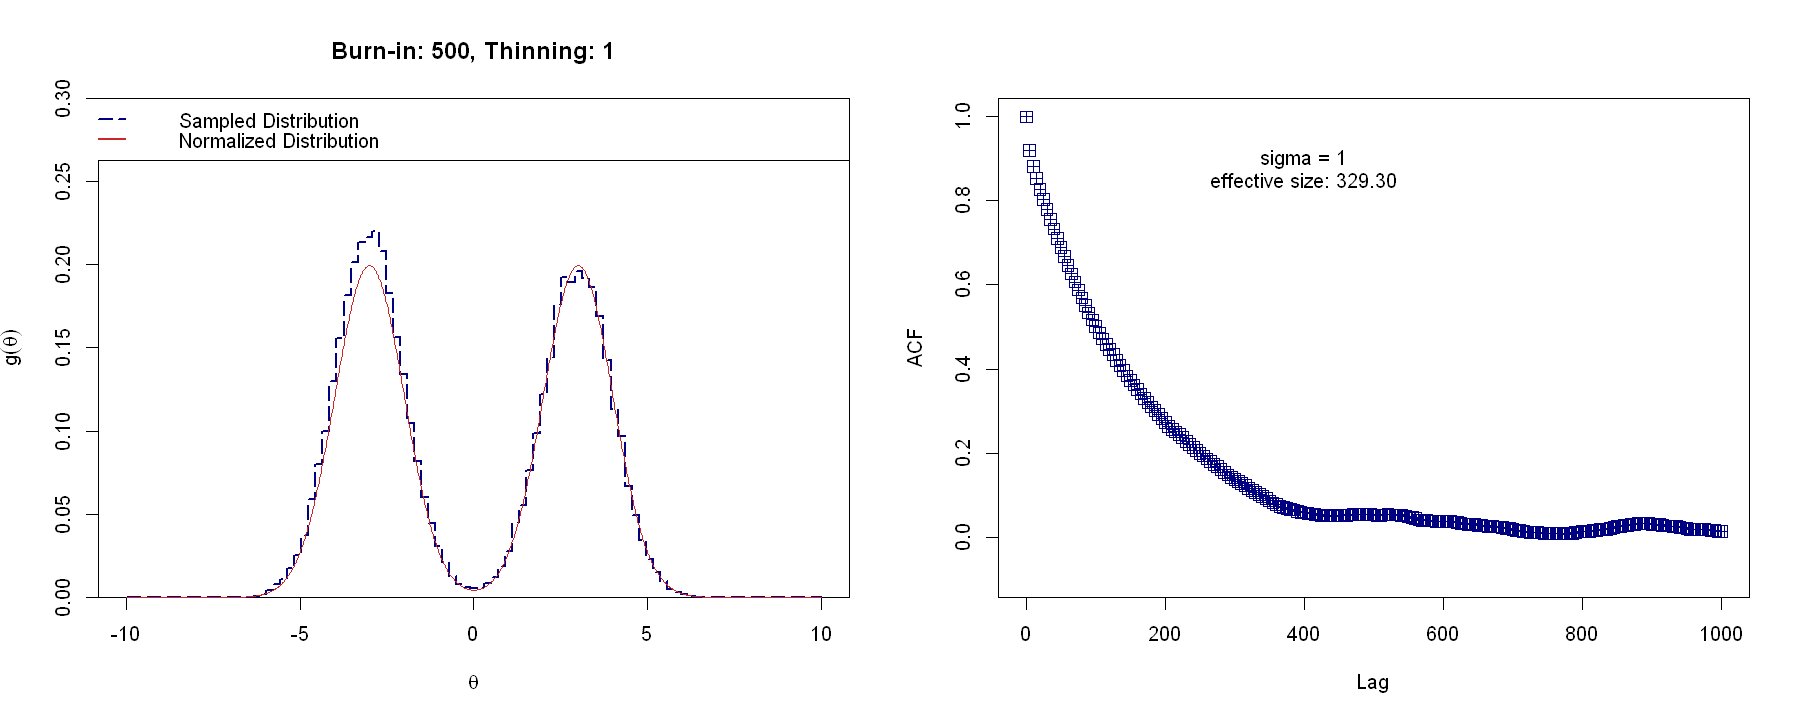

Acceptance Rate: 0.71203

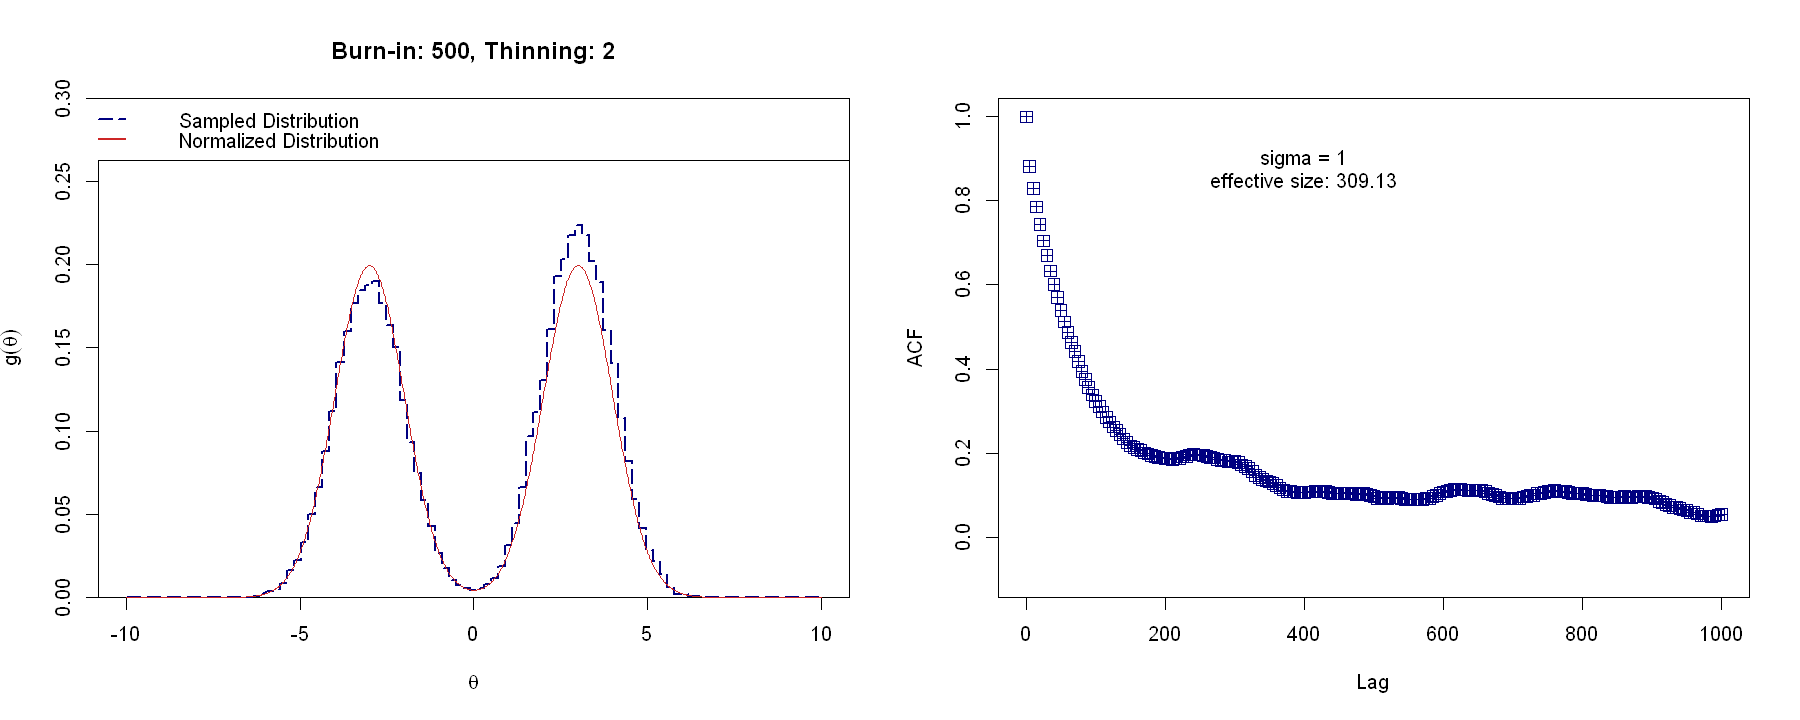

Acceptance Rate: 0.71207

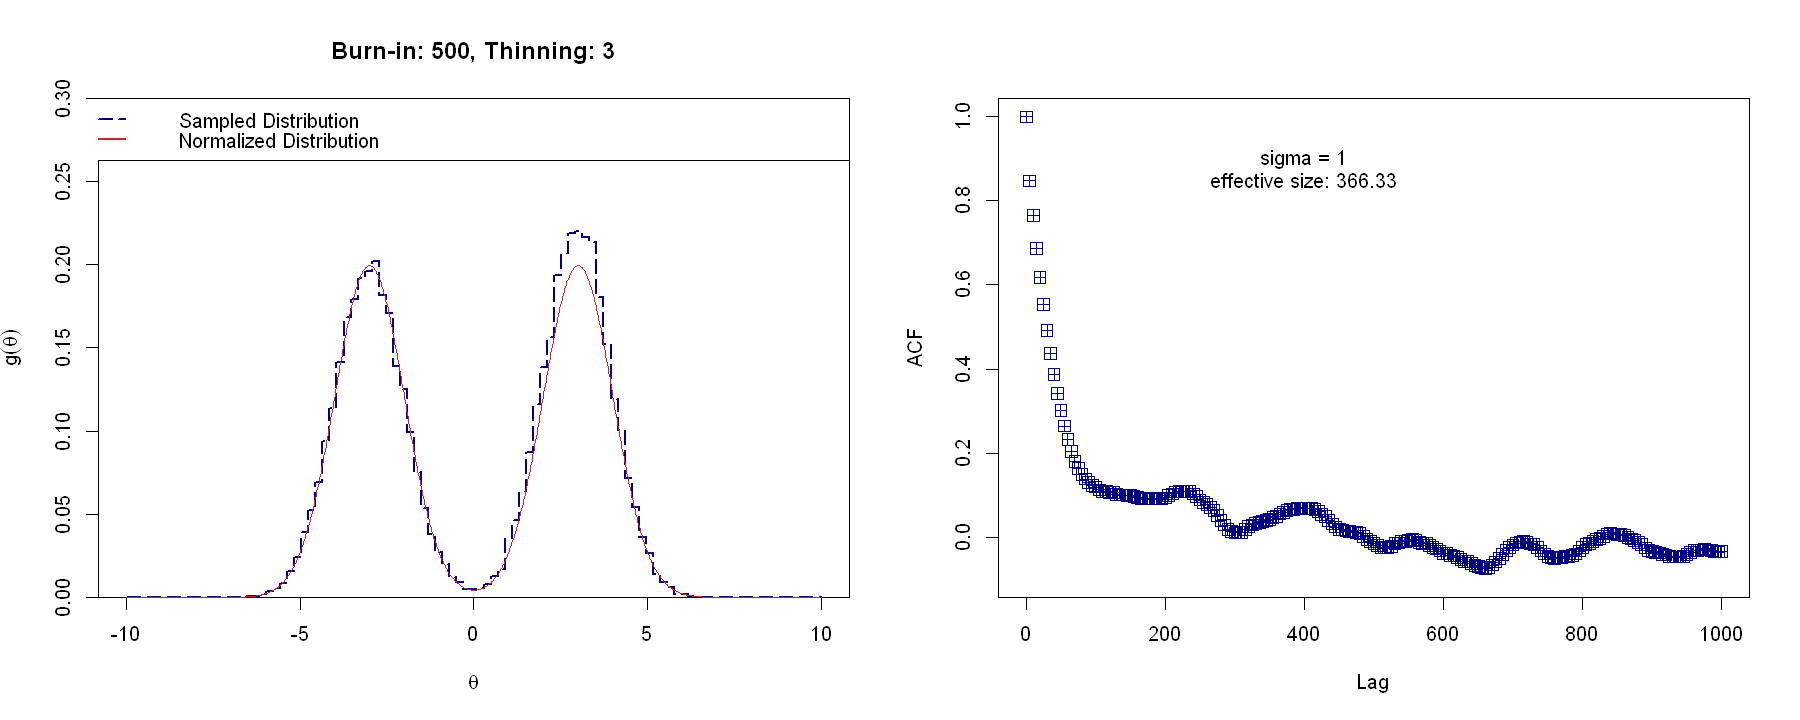

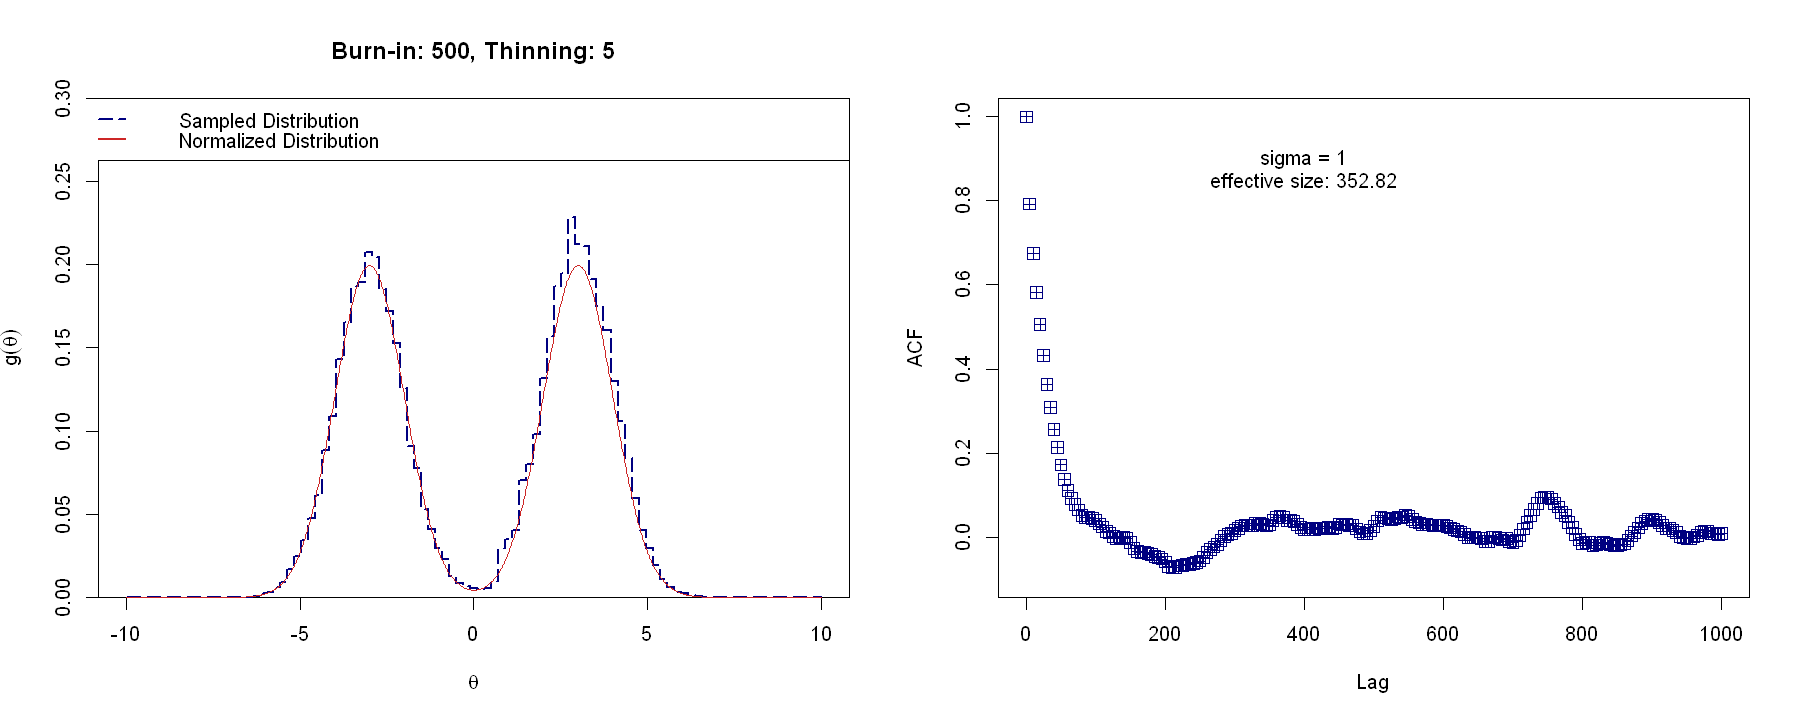

In [48]:
# Perform multiple runs with different burn-in and thinning settings
burn_in_values <- c(0, 50, 100, 500)
thinning_values <- c(1, 2, 3, 5)


for (b in burn_in_values) {
  for (t in thinning_values){
    burn_in <- b
    thinning <- t

    chain_new <- metropolis_new(func = g.metropolis,
                             theta.init = theta.init,
                             n.sample = n.sample,
                             sigma = sample.sig,
                             burn_in = b,
                             thinning = t,
                             n.accept = n.accept)

     
    g <- function(theta) {
    return (0.5 * exp(-(theta + 3)^2 / 2) + 0.5 * exp(-(theta - 3)^2 / 2))
    }
    
    x <- seq(-10, 10, length.out = 10^4)
    y <- g(x)
    ymax <- 1.05 * max(y)
    
    # Plot the sampled distribution
    smp <- normalize(g, -10, 10)

    par(mfrow = c(1, 2))
    options(repr.plot.width=15, repr.plot.height=6)
    plot(smp$x, smp$y, type = "n", yaxs = "i", ylim = c(0, 0.30),
         xlab = expression(theta), ylab = expression(g(theta)),
         main = paste0("Burn-in: ", b, ", Thinning: ", t))

    
    sa <- which(chain_new >= min(smp$x) & chain_new <= max(smp$x))
    #chain_values <- as.numeric(chain_new[sa, 2])  # Convert to numeric vector
    hist <- hist(as.numeric(chain_new[sa]), breaks = seq(from = min(smp$x), to = max(smp$x), length.out = 100), plot = FALSE)
    Zhist <- sum(hist$counts) * diff(range(hist$breaks)) / length(hist$counts) * max(y)
    lines(hist$breaks, c(hist$counts * ymax / Zhist, 0), col = 'navy', type = "s", lwd = 2, lty = 5)
    
    lines(smp$x, smp$y, col = 'firebrick3', lwd = 1, lty = 1)
    
    # Add legend
    legend("topright", legend = c("Sampled Distribution", "Normalized Distribution"),
           col = c("navy", "firebrick3"), lwd = 2, lty = c(5, 1))
  



# Calculate autocorrelation of the chain
chain_mcmc <- as.mcmc(chain_new)
my_lags <- seq(0, 1000, 5)
chain_acf <- autocorr(chain_mcmc, lags = my_lags)

# Plot the autocorrelation
plot(my_lags, chain_acf, ylim = c(-0.10, 1),
     pch = 12, col = 'navy',
     xlab = 'Lag', ylab = 'ACF', cex = 1.3)
text(400, 0.9, paste('sigma = 1'))
text(400, 0.85, sprintf("effective size: %.2f", effectiveSize(chain_mcmc)))
}
}

With `thinning = 3` and `burn-in = 50`, we can see the algorithm performing well. The autocorrelation plot shows a rapid decrease towards values around zero or within a small range, indicating that the chain has converged to the target distribution, and the samples are effectively exploring the distribution without much dependence on previous samples.
Increasing the burn-in value, the autocorrelation plot shows a slower decrease towards zero, indicating that the chain is not yet converged and the samples are still dependent on the previous one. Also the histogram is not yet well approximating the target distribution.

# Exercise 2

## Janssen

In [52]:
tot_vaccine <- 19360
tot_placebo <- 19691
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
janssen.tb <- tibble(tested = tested , patient=patient)
table(janssen.tb[[2]], janssen.tb[[1]])

         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19244   116

In [53]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(janssen.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(janssen.tb$patient )),
Ntot = nrow(janssen.tb) ,
Nclass = nlevels(factor(janssen.tb$patient ))
)

# Run the model
janssen_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(janssen_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Sat Jun 03 11:50:44 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39051
   Unobserved stochastic nodes: 2
   Total graph size: 78110
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01592100,0.01772215,0.01957040,0.017736230,0.0009346662,NA,4.665042e-06,0.5,40142,-0.005746412,1.000011
theta[2],0.00507254,0.00610288,0.00724403,0.006118324,0.0005582059,NA,2.794116e-06,0.5,39912,-0.004971253,1.000094


In [14]:
janssen_chains.df <- as.data.frame(as.mcmc(janssen_chains))

# Add the differential rate (efficacy of the vaccine)
janssen_res <- janssen_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_janssen <- as.mcmc(janssen_res[,'diff_rate'])
summary(allmcmc2_janssen)

Warning message in as.mcmc.runjags(janssen_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      65.42903        3.66347        0.01832        0.01832 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
57.84 63.05 65.59 68.00 72.16 


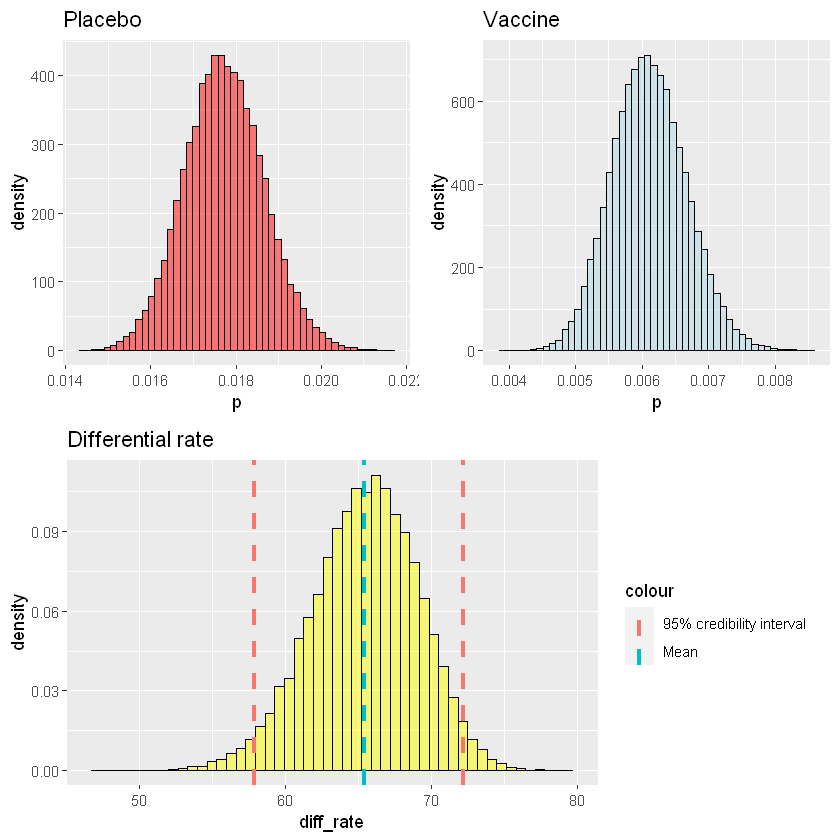

In [39]:
ggplot() +
geom_histogram(aes(x=janssen_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=janssen_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='lightblue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=janssen_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=57.84, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=72.16, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=65.43, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

## Moderna

In [54]:
tot_vaccine <- 14134
tot_placebo <- 14073
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 11
pos_placebo <- 185
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
moderna.tb <- tibble(tested = tested , patient=patient)
table(moderna.tb[[2]], moderna.tb[[1]])

         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11

In [55]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(janssen.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(moderna.tb$patient )),
Ntot = nrow(moderna.tb) ,
Nclass = nlevels(factor(moderna.tb$patient))
)

# Run the model
moderna_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(moderna_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Sat Jun 03 11:52:41 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 67266
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02226410,0.024745800,0.02737940,0.024767043,0.0013081683,NA,6.597110e-06,0.5,39321,0.0009375505,1.000001
theta[2],0.00689257,0.008336745,0.00988999,0.008352478,0.0007654383,NA,3.818985e-06,0.5,40172,-0.0034163907,1.000138


In [57]:
moderna_chains.df <- as.data.frame(as.mcmc(moderna_chains))

# Add the differential rate (efficacy of the vaccine)
moderna_res <- moderna_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_moderna <- as.mcmc(moderna_res[,'diff_rate'])
summary(allmcmc2_moderna)

Warning message in as.mcmc.runjags(moderna_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      66.18090        3.58884        0.01794        0.01792 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
58.71 63.84 66.30 68.69 72.80 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


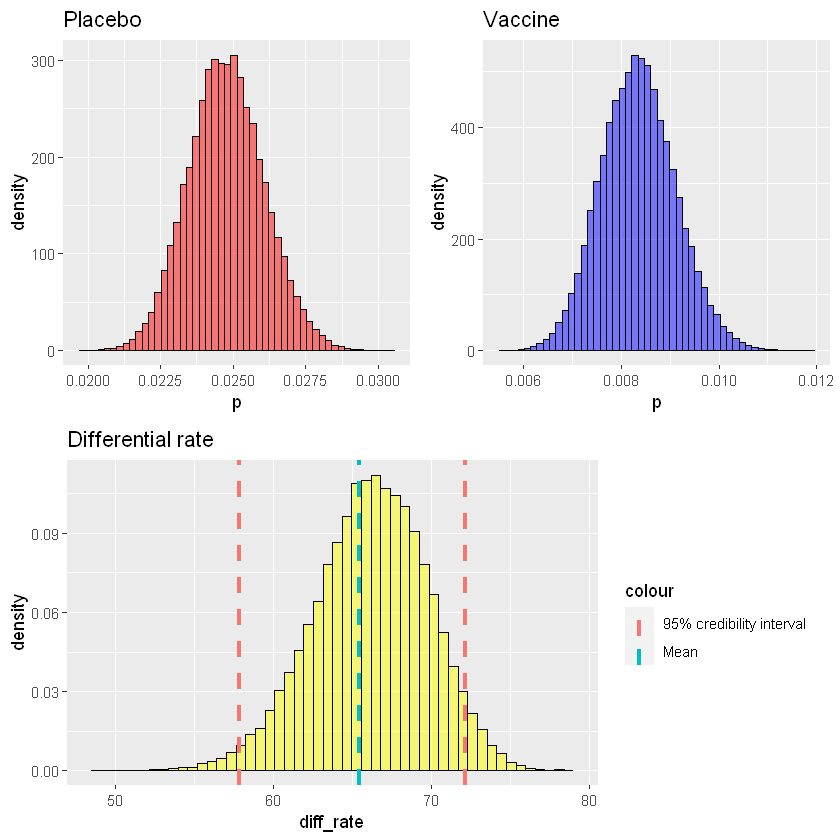

In [58]:
ggplot() +
geom_histogram(aes(x=moderna_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=moderna_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='blue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=moderna_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=57.84, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=72.16, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=65.42, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

## Astrazeneca

In [42]:
tot_vaccine <- 5258
tot_placebo <- 5210
patient <- c(rep("Vaccine", tot_vaccine),
rep("Placebo", tot_placebo ))
# Number of patients tested postive after RCT:
pos_vaccine <- 64
pos_placebo <- 154
tested <- c(rep("Pos", pos_vaccine),
rep("Neg", tot_vaccine - pos_vaccine),
rep("Pos", pos_placebo),
rep("Neg", tot_placebo - pos_placebo ))
astra.tb <- tibble(tested = tested , patient=patient)
table(astra.tb[[2]],astra.tb[[1]])

         
           Neg  Pos
  Placebo 5056  154
  Vaccine 5194   64

In [44]:
# Define the JAGS model with beta(3, 100) prior
model <- "model_covid.txt"

# Organize the data in a list
dataList = list(
tested = ifelse(astra.tb$tested == "Neg", 0, 1),
patient = as.integer(factor(astra.tb$patient )),
Ntot = nrow(astra.tb) ,
Nclass = nlevels(factor(astra.tb$patient))
)

# Run the model
astra_chains <- run.jags(
  model = model,
  data = dataList,
  n.chains = 4,
  method = "parallel",
  monitor = c("theta")
)
summary(astra_chains)

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.1.0 on Wed May 31 11:33:02 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20944
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 10000
-------------------------------------------------| 10000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02515040,0.02949150,0.0342706,0.02956180,0.002329160,NA,1.181688e-05,0.5,38850,-0.001490268,0.9999628
theta[2],0.00955126,0.01244255,0.0154593,0.01249872,0.001516909,NA,7.617089e-06,0.5,39659,-0.006132956,0.9999975


In [46]:
astra_chains.df <- as.data.frame(as.mcmc(astra_chains))

# Add the differential rate (efficacy of the vaccine)
astra_res <- astra_chains.df %>%
select('theta[1]','theta[2]') %>%
rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
Placebo_perc = Placebo * 100,
Vaccine_perc = Vaccine * 100)

# Encapsulate the data
allmcmc2_astra <- as.mcmc(astra_res[,'diff_rate'])
summary(allmcmc2_astra)

Warning message in as.mcmc.runjags(astra_chains):
"Combining the 4 mcmc chains together"



Iterations = 1:40000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 40000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      57.45469        6.19695        0.03098        0.03098 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
44.22 53.59 57.88 61.78 68.42 


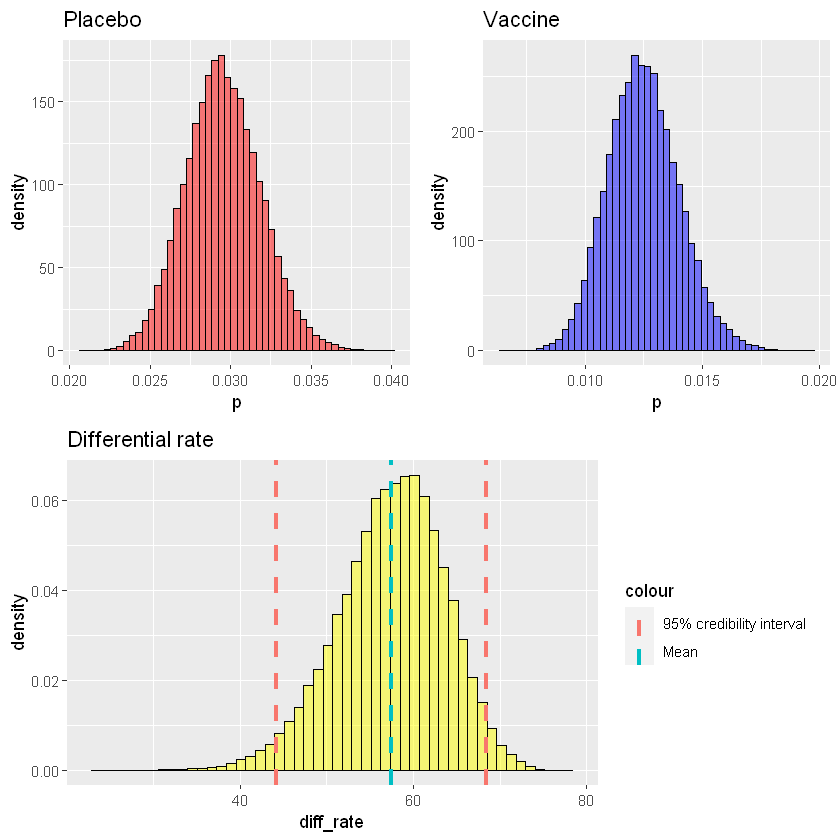

In [48]:
ggplot() +
geom_histogram(aes(x=astra_chains.df[['theta[1]']], y=after_stat(density)), color='black', fill='red', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Placebo') -> plot_placebo

ggplot() +
geom_histogram(aes(x=astra_chains.df[['theta[2]']], y=after_stat(density)), color='black', fill='blue', alpha=0.5, bins=50) +
labs(x='p', y='density', title='Vaccine') -> plot_vaccine

ggplot()+
geom_histogram(aes(x=astra_res$diff_rate, y=after_stat(density)), color='black', fill='yellow', alpha=0.5, bins = 50)+
geom_vline(aes(xintercept=44.22, color='95% credibility interval'), linetype='dashed', size=1.2) +
geom_vline(aes(xintercept=68.42, color='95% credibility interval'), linetype='dashed',  size=1.2) +
geom_vline(aes(xintercept=57.45, color='Mean'), linetype='dashed',  size=1.2) +
labs(x ='diff_rate', y='density', title='Differential rate') -> plot_diffrate

grid.arrange(plot_placebo, plot_vaccine, plot_diffrate, layout_matrix=rbind(c(1,2),c(3,3)))

# Exercise 3

Rows: 170463 Columns: 16
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (2): location, iso_code
dbl  (13): total_vaccinations, people_vaccinated, people_fully_vaccinated, t...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


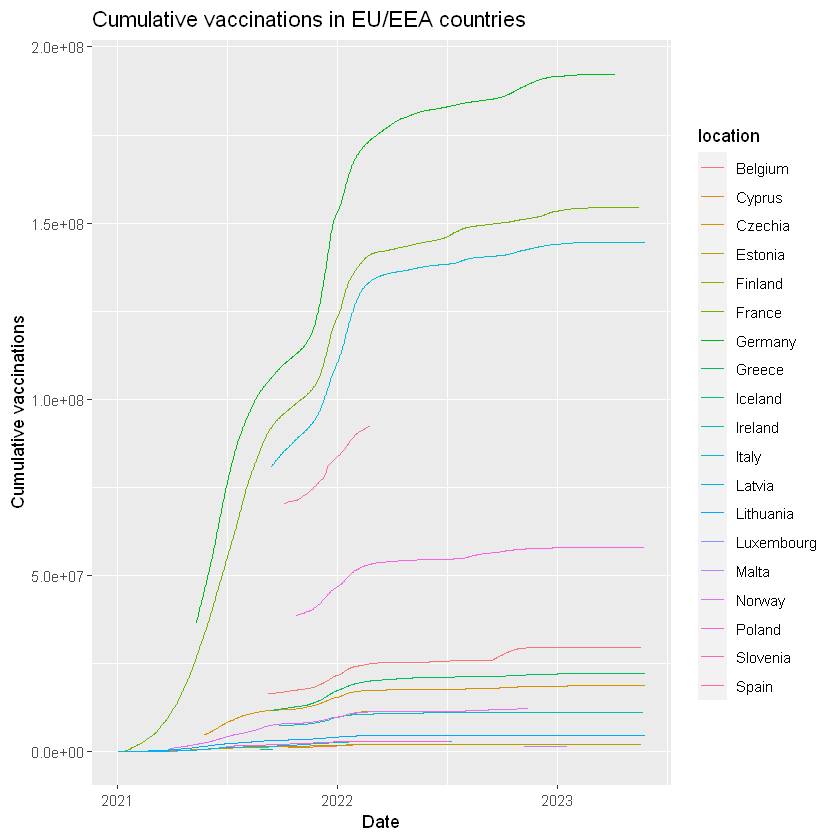

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


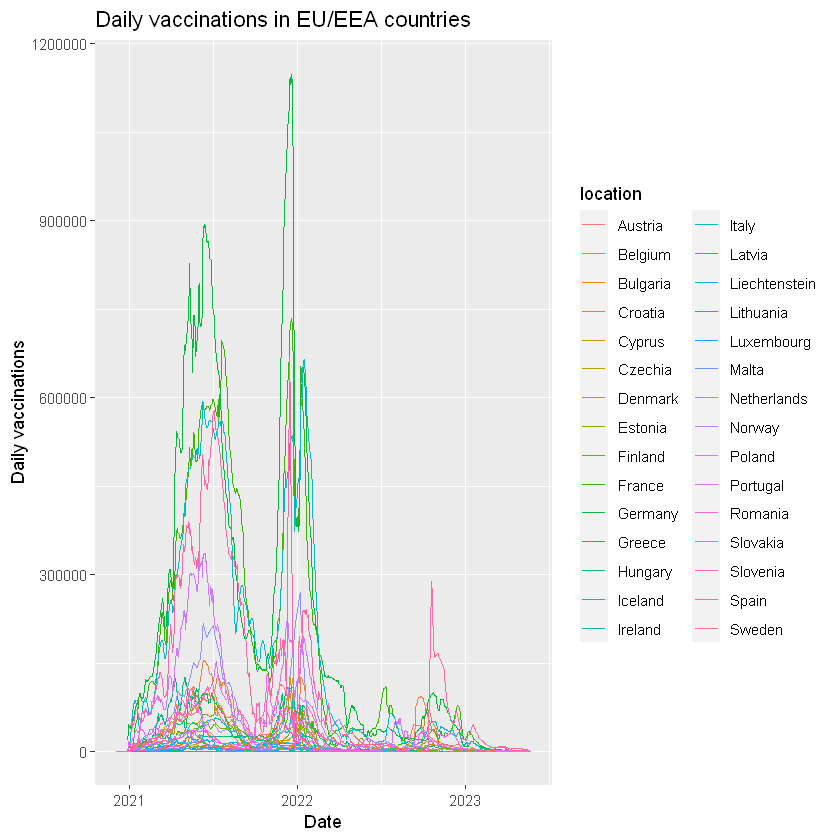

Rows: 313167 Columns: 67
-- Column specification --------------------------------------------------------
Delimiter: ","
chr   (4): iso_code, continent, location, tests_units
dbl  (62): total_cases, new_cases, new_cases_smoothed, total_deaths, new_dea...
date  (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Removed 677 rows containing missing values (`geom_line()`)."


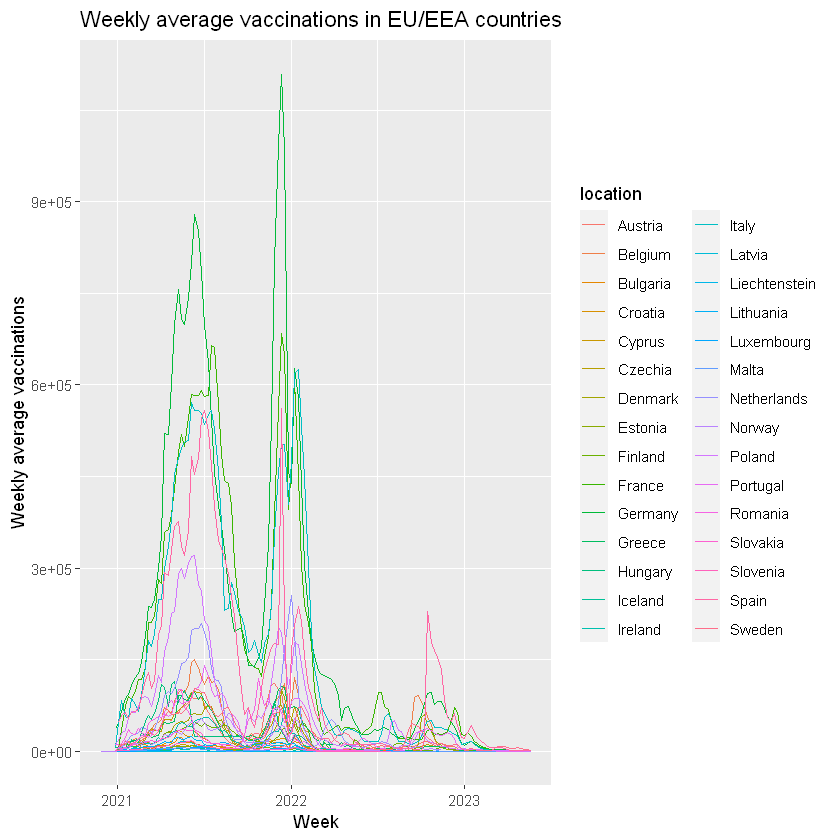

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.
Warning message:
"Removed 19 rows containing missing values (`geom_line()`)."


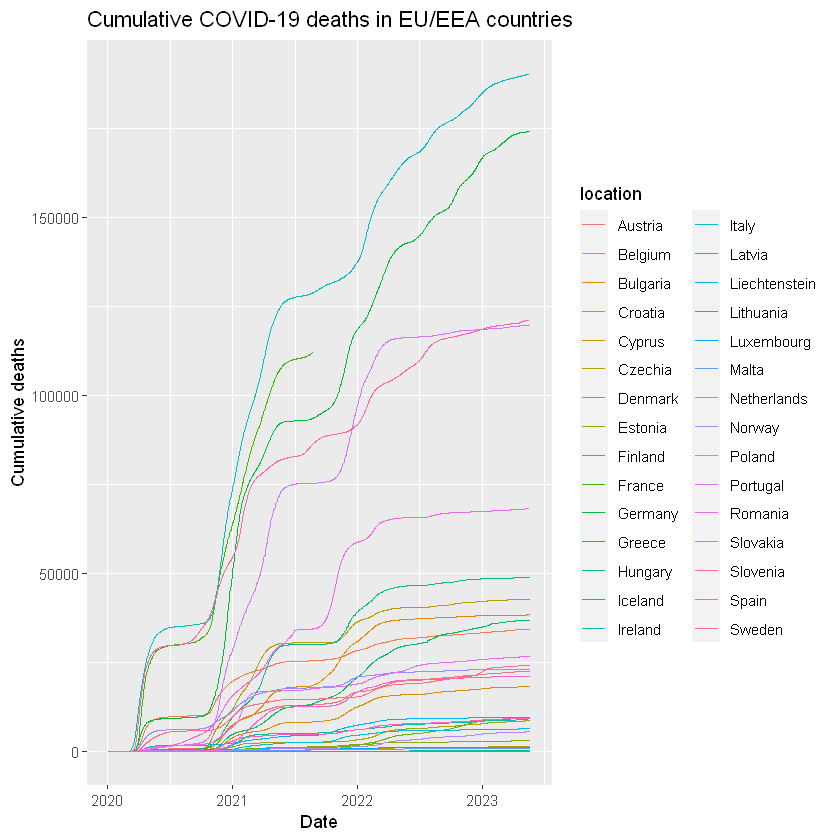

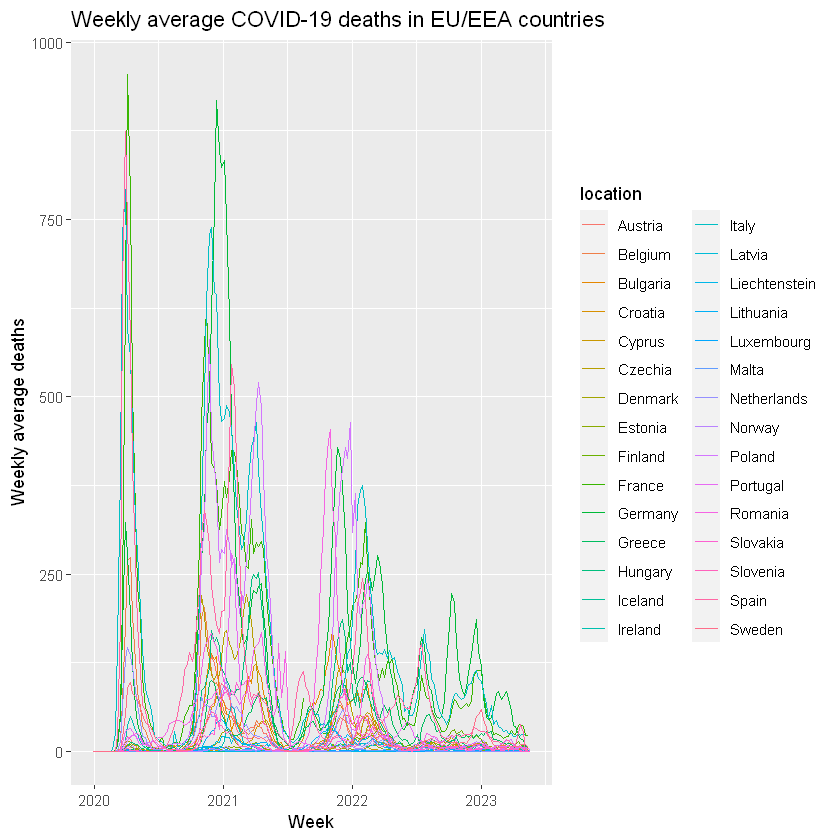

In [9]:
# Read in data
data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# Filter for EU/EEA countries
eu_eea_countries <- c("Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden")
data_eu_eea <- data %>% filter(location %in% eu_eea_countries & !is.na(daily_vaccinations))

# Calculate cumulative vaccinations
cumulative_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_vaccinations = cumsum(daily_vaccinations)) %>%
  ungroup()

# Plot cumulative vaccinations
cumulative_vaccinations %>%
  na.omit() %>%
  ggplot(aes(x = date, y = cumulative_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Cumulative vaccinations in EU/EEA countries",
       x = "Date",
       y = "Cumulative vaccinations")

# Calculate daily vaccinations
daily_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(daily_vaccinations = daily_vaccinations) %>%
  ungroup()

# Plot daily vaccinations
daily_vaccinations %>%
  ggplot(aes(x = date, y = daily_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Daily vaccinations in EU/EEA countries",
       x = "Date",
       y = "Daily vaccinations")

# Calculate weekly average vaccinations
weekly_avg_vaccinations <- data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_vaccinations = mean(daily_vaccinations)) %>%
  ungroup()

# Plot weekly average vaccinations
weekly_avg_vaccinations %>%
  ggplot(aes(x = week, y = weekly_avg_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Weekly average vaccinations in EU/EEA countries",
       x = "Week",
       y = "Weekly average vaccinations")

# Read in deaths data
deaths_data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

# Filter for EU/EEA countries
deaths_data_eu_eea <- deaths_data %>% filter(location %in% eu_eea_countries)

# Calculate cumulative deaths
cumulative_deaths <- deaths_data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_deaths = cumsum(new_deaths)) %>%
  ungroup()

# Plot cumulative deaths
cumulative_deaths %>%
  ggplot(aes(x = date, y = cumulative_deaths, color = location)) +
  geom_line() +
  labs(title = "Cumulative COVID-19 deaths in EU/EEA countries",
       x = "Date",
       y = "Cumulative deaths")

# Calculate weekly average deaths
weekly_avg_deaths <- deaths_data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_deaths = mean(new_deaths)) %>%
  ungroup()

# Plot weekly average deaths
weekly_avg_deaths %>%
  ggplot(aes(x = week, y = weekly_avg_deaths, color = location)) +
  geom_line() +
  labs(title = "Weekly average COVID-19 deaths in EU/EEA countries",
       x = "Week",
       y = "Weekly average deaths")